<h1 style=font-size:36px;><u>Predicting Customer Churn in the Telco Industry</u></h1>

Customer Churn is an important characteristic in the telecommunications industry. Churn as I define, is where a customer has changed telco providers in a given period. This definition is not uncommon and goes hand in hand with the competitive nature of the industry. Major providers, such as Telstra and Optus, actively compete to offer the best deals to attract customers and maintain a higher rate of customer retention. 

The dataset gathered, downloaded from Kaggle, makes use of a hypotheical company. This company has thousands of customers, along with various attributes, where the main goal will be to predict whether a given customer will churn or not. Various machine learning models will be used and compared against to determine which model returns the best results. Along the way, we'll explore the data by making use of visualisations to gain better insights and understandings. 

<h1>Load Packages</h1>

In [4]:
# Hide all warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
#!pip install torch livelossplot #tensorboard

In [6]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import plotly.express as px
import re 

from joblibspark import register_spark
from sklearn.utils import parallel_backend

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb # need to install brew, then type in terminal: brew install libomp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
#from torch.utils.tensorboard import SummaryWriter # tensorboard

# NOTE: keras requires tensorflow version 2.2 or higher (I'm using 2.0)
#import tensorflow as tf
#from tensorflow import keras
#from keras.models import load_model
#from tensorflow.keras import layers
#from tensorflow.keras import regularizers

from IPython.core.display import display, HTML # HTML in code cells

from livelossplot import PlotLosses

%matplotlib inline

sns.set(style='darkgrid')

register_spark() # register spark backend

<h1>Importing and Tidying the Data</h1>

In [7]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [9]:
# First we'll drop the customerID column, since each customer can be identified by its index value.
df.drop("customerID", axis=1, inplace=True)

In [10]:
# Check for Missing Values
def missing_values(df):
    mv = df.isnull().sum().sort_values(ascending=False)
    percentage = round(mv / len(df) * 100, 2)  # rounded 2 dp
    df_mv = pd.concat([mv, percentage], axis=1, keys=['Total', 'Percentage'])
    if sum(mv > 0) != 0:
        return df_mv.loc[df_mv['Total'] > 0]
    else:
        return print("No Missing Values")

missing_values(df)

No Missing Values


In [11]:
# Inspecting for numerical indicator variables
def print_non_cat_values(df):
    for col in df.columns:
        if df[col].dtype not in ['object', 'bool']:
            print(f'{col}:', '\n', df[col].unique()[0:15], '\n')

print_non_cat_values(df)

SeniorCitizen: 
 [0 1] 

tenure: 
 [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69] 

MonthlyCharges: 
 [ 29.85  56.95  53.85  42.3   70.7   99.65  89.1   29.75 104.8   56.15
  49.95  18.95 100.35 103.7  105.5 ] 



`SeniorCitizen` is the only indicator variable where 1 represents a senior citizen and 0 the opposite.

For visualisation purposes, we'll convert this into an object (string) where 1 = SC and 0 = non_SC. (We'll convert back later in modelling step).

In [12]:
df["SeniorCitizen"].replace({0: "No", 1: "Yes"}, inplace=True)

In [14]:
# Inspect categorical columns for alternate-spellings/mistakes
def print_cat_values(df):
    for col in df.columns:
        if df[col].dtype in ['object', 'bool']:
            print(f'{col}:', '\n', df[col].unique()[0:15], '\n')

print_cat_values(df)

gender: 
 ['Female' 'Male'] 

SeniorCitizen: 
 ['No' 'Yes'] 

Partner: 
 ['Yes' 'No'] 

Dependents: 
 ['No' 'Yes'] 

PhoneService: 
 ['No' 'Yes'] 

MultipleLines: 
 ['No phone service' 'No' 'Yes'] 

InternetService: 
 ['DSL' 'Fiber optic' 'No'] 

OnlineSecurity: 
 ['No' 'Yes' 'No internet service'] 

OnlineBackup: 
 ['Yes' 'No' 'No internet service'] 

DeviceProtection: 
 ['No' 'Yes' 'No internet service'] 

TechSupport: 
 ['No' 'Yes' 'No internet service'] 

StreamingTV: 
 ['No' 'Yes' 'No internet service'] 

StreamingMovies: 
 ['No' 'Yes' 'No internet service'] 

Contract: 
 ['Month-to-month' 'One year' 'Two year'] 

PaperlessBilling: 
 ['Yes' 'No'] 

PaymentMethod: 
 ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'] 

TotalCharges: 
 ['29.85' '1889.5' '108.15' '1840.75' '151.65' '820.5' '1949.4' '301.9'
 '3046.05' '3487.95' '587.45' '326.8' '5681.1' '5036.3' '2686.05'] 

Churn: 
 ['No' 'Yes'] 



Looks like `TotalCharges` is being read as an object and not as a float, so we'll first change this. Otherwise, everything seems to be fine.

In [15]:
# NOTE: TotalCharges won't convert to float since there are whitespace cells present
def check_whitespaces(df):
    for col in df.columns:
        if df[col].dtype in ['object', 'bool']:
            ws = df[col].str.match('\s+').sum()
            if ws != 0:
                print(col, ws)

check_whitespaces(df)

TotalCharges 11


11 to be exact. So, we'll convert these to `np.nan` values, then check aggregate statistics to see whether we should drop these values.

In [16]:
df["TotalCharges"].replace(" ", np.nan, inplace=True)
df["TotalCharges"] = df["TotalCharges"].astype('float64')

In [17]:
df.groupby("Churn")[["MonthlyCharges", "tenure", "TotalCharges"]].agg(["min", "max", "mean", "median"])

MonthlyCharges                            tenure                        \
                 min     max       mean  median    min max       mean median   
Churn                                                                          
No             18.25  118.75  61.265124  64.425      0  72  37.569965     38   
Yes            18.85  118.35  74.441332  79.650      1  72  17.979133     10   

      TotalCharges                                 
               min      max         mean   median  
Churn                                              
No           18.80  8672.45  2555.344141  1683.60  
Yes          18.85  8684.80  1531.796094   703.55

The minimum of `TotalCharges` for either churned or not is > 0. So setting these values to 0 would obviously skew the data, but since there are so few missing values (11), we will just drop them.

In [18]:
df.dropna(inplace = True)
df.reset_index(drop=True, inplace=True)

In [19]:
df.shape # previous shape was 7043, 21 => 11 rows have been deleted, along with 1 column

(7032, 20)

Next, we'll check the number of occurrences for each unique value in each categorical feature. This is to make sure the classes in each feature are not disproportionate, otherwise, that feature will be of no importance.

Note: If there are so few occurrences of particular classes in certain features, then two techniques could be used:  

     1. Data Augmentation - generate new instances in training sample
     2. Drop those rows
     
More often than not, we would apply the second procedure, however, if using data in reference to say fraud, then more than likely you'll need to apply the first procedure as there will be so few fraudulent transactions.

In [20]:
def check_class_props_for_cats(df, percentage):
    '''
    If the proportion of occurrence of at least 1 class in the ith categorical feature is less than 
    `percentage`, return value_counts for the ith feature, iterating through all features.
    '''
    occurrences = 0
    for col in df.columns:
        if df[col].dtype in ['object', 'bool']:
            val_counts = df[col].value_counts()
            val_counts_percent = val_counts/len(df) * 100
            for value in val_counts_percent:
                if value < percentage:
                    print(val_counts, '\n')
                    occurrences += 1
                    break
    if occurrences == 0:
        print("No features have any classes with proportions less than " + str(percentage) + "%.")
    

check_class_props_for_cats(df, 5)

No features have any classes with proportions less than 5%.


Terrific, the proportion of classes in each non-numeric feature look good.

<h1>Exploratory Data Analysis</h1>

In [21]:
# Make copy of data
df_eda = df.copy()

<h3>Payment Method vs Total Charges by Churn</h3>

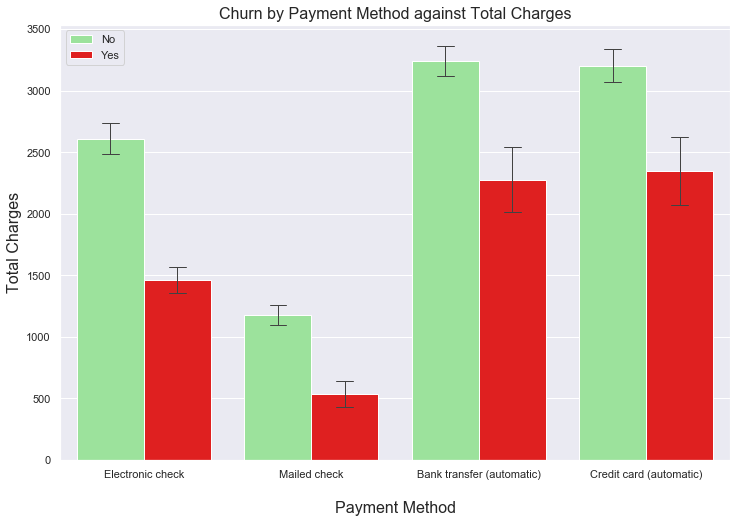

In [56]:
plt.figure(figsize=(12, 8))
sns.barplot(x="PaymentMethod",
            y="TotalCharges",
            hue="Churn",
            data=df_eda,
            ci=95,
            errwidth=1,  # thickness of error bar lines
            capsize=0.1,
            palette={'Yes':'red', 'No':'lightgreen'})   # width on error bar caps
plt.title("Churn by Payment Method against Total Charges", fontsize=16)
plt.xlabel("\nPayment Method", fontsize=16)
plt.xticks(rotation=0)
plt.ylabel("Total Charges", fontsize=16)
plt.legend(loc="upper left");

On average, for all 4 methods the total charges for customers who have churned is less than that for customers who have not churned. Surprisingly, you may think that the opposite is true, however, most customers may in fact not be people, but rather companies/organisations that are paying more due to their size.

<h3>Comparison between Customer Tenure and Churn</h3>

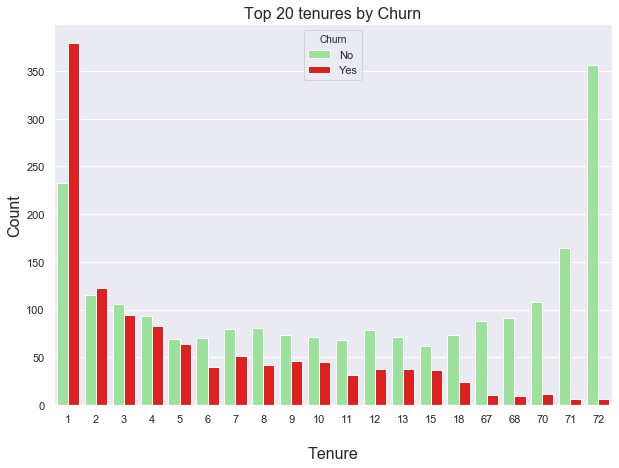

In [63]:
top_20_tenure_values = (df_eda['tenure'].value_counts()[0:20]
                                        .index
                                        .tolist())
top_20_tenure_churn = df_eda[['tenure',"Churn"]][df_eda['tenure'].isin(top_20_tenure_values)]

plt.figure(figsize=(10, 7))
sns.countplot(x = "tenure", hue = 'Churn', data = top_20_tenure_churn, palette={'Yes':'red', 'No':'lightgreen'})
plt.title("Top 20 tenures by Churn", fontsize=16)
plt.xlabel("\nTenure", fontsize=16)
plt.ylabel("Count", fontsize=16);

In the top 20 most occurring tenures by customer is years 1 to 15 and years 67 to 72 excluding year 69. We would expect this since most customers in the earlier years are highly volatile as to whether or not they stay with the company, whereas in the later years most customers (probably large companies) have been with the telco provider since the start of their lifetime. 

Clearly, the majority of customers in their first year are very volatile and subject to churning. However, observing the latter years, especially year 72, there is very little volatility as to whether a customer will churn. 

The defining strategy here would be to try and retain those customers, especially customers in the first 2 years coming off contract. 

<h3>How Total Charges effects Customer Churn</h3>

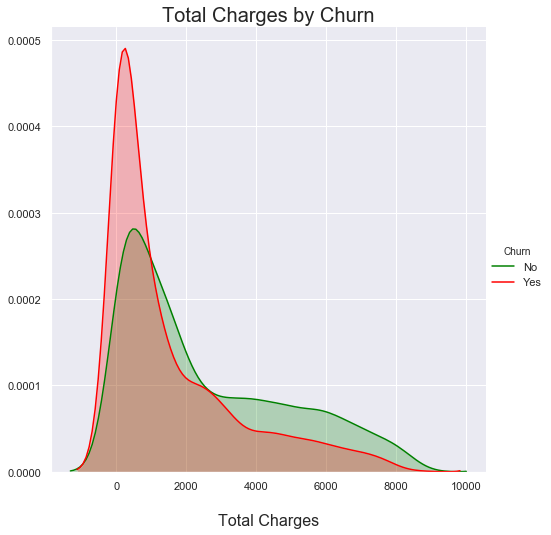

In [71]:
(sns.FacetGrid(df_eda, hue='Churn', height=7, palette={'Yes':'red', 'No':'green'})
    .map(sns.kdeplot, 'TotalCharges', shade = True)
    .set_xlabels('Total Charges', fontdict = {'fontsize': 12})
    .add_legend());
plt.title('Total Charges by Churn', fontdict = {'fontsize': 20})
plt.xlabel("\nTotal Charges", fontsize=16);

The figure shows that roughly after a total charge of $1,000 the customer churn rate is lower than that of the non-churn rate. The most probable cause here would be individual consumers who are more likely susceptible to change, rather than companies.

<h3>How Gender, Partner, SeniorCitizen and Dependents all compare to Churn</h3>

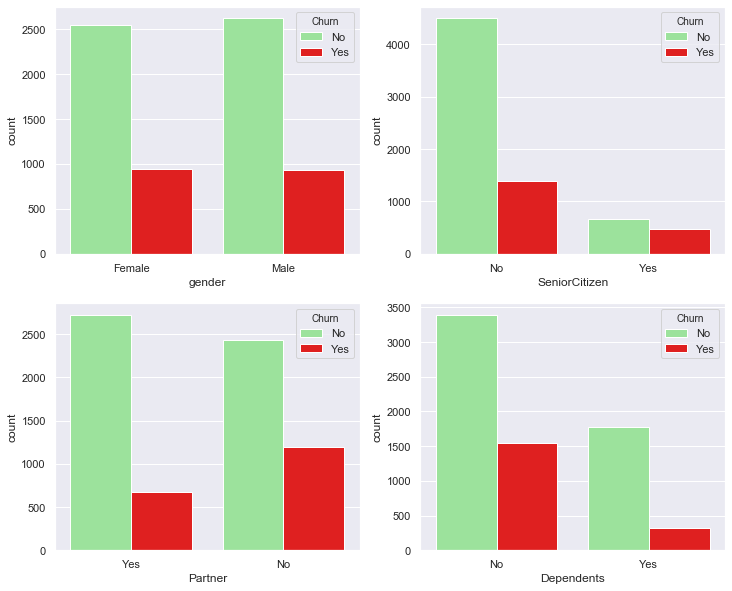

In [69]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))
sns.countplot(x = "gender", hue = 'Churn', data = df_eda, palette={'Yes':'red', 'No':'lightgreen'}, ax=ax[0,0]);
sns.countplot(x = "SeniorCitizen", hue = 'Churn', data = df_eda, palette={'Yes':'red', 'No':'lightgreen'}, ax=ax[0,1]);
sns.countplot(x = "Partner", hue = 'Churn', data = df_eda, palette={'Yes':'red', 'No':'lightgreen'}, ax=ax[1,0]);
sns.countplot(x = "Dependents", hue = 'Churn', data = df_eda, palette={'Yes':'red', 'No':'lightgreen'}, ax=ax[1,1]);

In all 4 visualisations theres not once where churn is greater than non-churn. However, for customers that are senior citizens the number of churns is almost inline with that of no churns, most likely due to underlying health conditions. It may also be worth pointing out that if a customer has a partner, churn is about half of what the churn is for no partner. As well, if a customer has dependents then their less likely to churn.

<h3>Is Churn due to Device Protection?</h3>

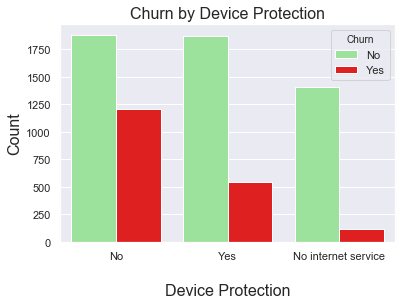

In [73]:
sns.countplot(x = "DeviceProtection", hue = 'Churn', data = df_eda, palette={'Yes':'red', 'No':'lightgreen'})
plt.title("Churn by Device Protection", fontsize=16)
plt.xlabel("\nDevice Protection", fontsize=16)
plt.ylabel("Count", fontsize=16);

Its quite clear that churn is greater when a customer doesn't have device protection. No surprise, because generally customers who are still contraced, that recently signed up, who break their phone while not insured are more likely to churn. We can check this hypothesis:

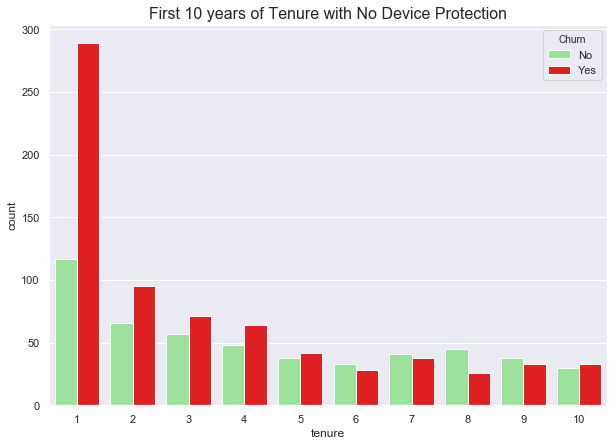

In [75]:
first_10_ten_dp_ch = df_eda[['tenure', "DeviceProtection", "Churn"]][df_eda['tenure'].isin([i+1 for i in range(10)])]
first_10_dp_no = first_10_ten_dp_ch[first_10_ten_dp_ch["DeviceProtection"] == "No"]

plt.figure(figsize=(10, 7))
sns.countplot(x = "tenure", hue = 'Churn', data = first_10_dp_no, palette={'Yes':'red', 'No':'lightgreen'})
plt.title("First 10 years of Tenure with No Device Protection", fontsize=16);

As hypothesised, customers with no device protection at all, in the first and second years of their tenure (also extends to year 5), are more likely to churn than not.

<h3>How Many Customers Churn that Stream Movies?</h3>

In [81]:
sm_ch_counts = df_eda.groupby(["StreamingMovies", "Churn"]).size().to_frame().reset_index().rename({0: "Counts"}, axis=1)
fig = px.bar(sm_ch_counts, x='StreamingMovies', y='Counts', color='Churn', color_discrete_sequence =['green', 'red'])
fig.update_layout(
    title={'text': "Senior Citizens who Stream Movies",
           'x':0.5})
fig.show()

Customers that don't have any internet service seem to remain the majority of the time. However, for customers that do and don't stream movies, there seems to be roughly a 25%-33% customer churn rate.  

<h3>How does Online Security and Backup relate to Churn?</h3>

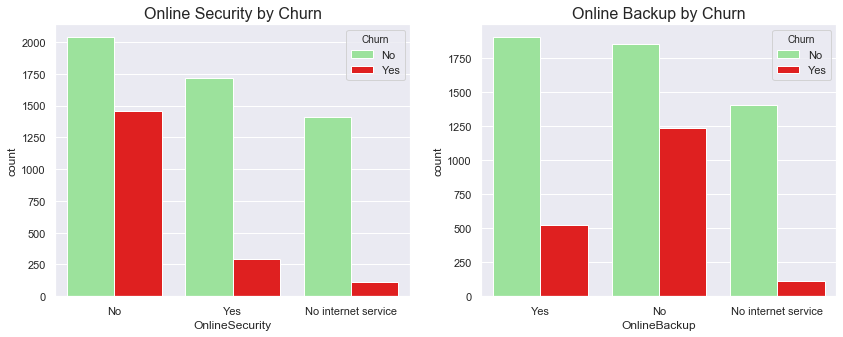

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax1 = sns.countplot(x="OnlineSecurity", hue = 'Churn', data=df_eda, palette={'Yes':'red', 'No':'lightgreen'}, ax=ax[0]);
ax1.set_title("Online Security by Churn", fontsize=16);
ax2 = sns.countplot(x="OnlineBackup", hue = 'Churn', data=df_eda, palette={'Yes':'red', 'No':'lightgreen'}, ax=ax[1]);
ax2.set_title("Online Backup by Churn", fontsize=16);

In either case, customers with no online security or backup are more likely to churn than customers who do. Customers who don't have internet service have a lower churn, most likely because they are not worried about these types of services. 

<h3>Is Churn directly affected by Monthly and Total Charges along with tenure?</h3>

In [84]:
fig = px.scatter(df_eda, x="MonthlyCharges", y="TotalCharges", color="Churn", size="tenure", color_discrete_sequence =['green', 'red'])
fig.update_layout(
    title={
        'text': "How Churn effected by Monthly vs Total Charges and Tenure",
        'x':0.5})
fig.show()

Theres a clear positive linear relationship between both Monthly and Total Charges. Also, when total charge is around 0, we see the circles are smaller meaning less tenure. This most probably resembles newer customers who have just recently signed up on a 1 to 2 year mobile phone contract. Most these small circles are red, meaning after there contract, these customers are more likely to churn.

As total charge increases for a constant monthly charge, we see the circles get much bigger, indicating a longer tenure. These customers who have monthly charges less than <span>&#36;</span>70 are more likely to stay with the company. However, when the monthly charge is above <span>&#36;</span>70, more customers are churning, indicating that these customers may be looking for alternate telco providers that can offer cheaper services.

<h1>Pre-Processing</h1>

In [85]:
df_pp = df_eda.copy()

<h3>Correlations</h3>

In [87]:
dfc = df_pp.copy()

In [88]:
# Firstly, encode categorical columns as integers
def enc_cat_features(df):
    global df_cat_encoded
    for col in df.columns:
        if df[col].dtype in ['object', 'bool']:
            lab_enc = LabelEncoder()
            df[col] = lab_enc.fit_transform(df[col])
            lab_enc_name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
            print(col, '\n', lab_enc_name_mapping, '\n')
    df_cat_encoded = df

enc_cat_features(dfc)

gender 
 {'Female': 0, 'Male': 1} 

SeniorCitizen 
 {'No': 0, 'Yes': 1} 

Partner 
 {'No': 0, 'Yes': 1} 

Dependents 
 {'No': 0, 'Yes': 1} 

PhoneService 
 {'No': 0, 'Yes': 1} 

MultipleLines 
 {'No': 0, 'No phone service': 1, 'Yes': 2} 

InternetService 
 {'DSL': 0, 'Fiber optic': 1, 'No': 2} 

OnlineSecurity 
 {'No': 0, 'No internet service': 1, 'Yes': 2} 

OnlineBackup 
 {'No': 0, 'No internet service': 1, 'Yes': 2} 

DeviceProtection 
 {'No': 0, 'No internet service': 1, 'Yes': 2} 

TechSupport 
 {'No': 0, 'No internet service': 1, 'Yes': 2} 

StreamingTV 
 {'No': 0, 'No internet service': 1, 'Yes': 2} 

StreamingMovies 
 {'No': 0, 'No internet service': 1, 'Yes': 2} 

Contract 
 {'Month-to-month': 0, 'One year': 1, 'Two year': 2} 

PaperlessBilling 
 {'No': 0, 'Yes': 1} 

PaymentMethod 
 {'Bank transfer (automatic)': 0, 'Credit card (automatic)': 1, 'Electronic check': 2, 'Mailed check': 3} 

Churn 
 {'No': 0, 'Yes': 1} 



In [95]:
df_cor = df_cat_encoded.corr()

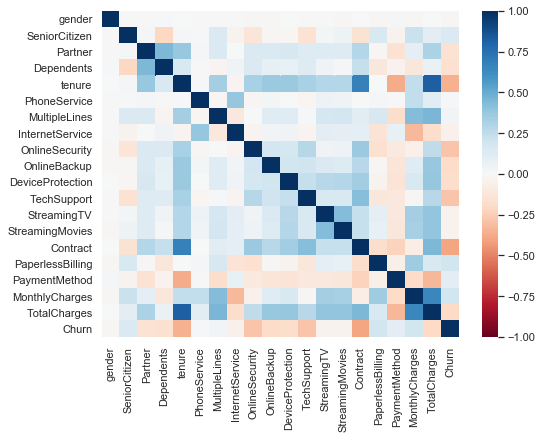

In [47]:
# Plot heatmap of the correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(df_cor,
            vmin=-1,
            vmax=1,
            cmap='RdBu');

Total Charges is highly positively correlated with tenure as well as positively correlated with monthly charges. Also, contract is positively correlated with contract. Nothing is highly negatively correlated.

We can check these precise values by the following:

In [99]:
# Returns the correlation pairs where the correlation is > pv or < nv
def check_corr_values(df, pv, nv):
    for x in range(len(df)):
        for y in range(len(df)):
            if ((df.iloc[x, y] > pv) | (df.iloc[x, y] < nv)):
                if df.index[x] == df.index[y]:
                    pass
                elif x < y:
                    print(df.index[x], '-', df.index[y] + ': ', round(df.iloc[x, y], 5))
                    
check_corr_values(df_cor, 0.6, -0.6)

tenure - Contract:  0.67673
tenure - TotalCharges:  0.82588
MonthlyCharges - TotalCharges:  0.65106


Indeed, tenure and total charges, out of the 3, is highly linear positively correlated.

In [49]:
# Checking the correlations of each variable with Churn
df_cor["Churn"].sort_values(ascending=False)

Churn               1.000000
MonthlyCharges      0.192858
PaperlessBilling    0.191454
SeniorCitizen       0.150541
PaymentMethod       0.107852
MultipleLines       0.038043
PhoneService        0.011691
gender             -0.008545
StreamingTV        -0.036303
StreamingMovies    -0.038802
InternetService    -0.047097
Partner            -0.149982
Dependents         -0.163128
DeviceProtection   -0.177883
OnlineBackup       -0.195290
TotalCharges       -0.199484
TechSupport        -0.282232
OnlineSecurity     -0.289050
tenure             -0.354049
Contract           -0.396150
Name: Churn, dtype: float64

Nothing is really highly positively/negatively correlated with Churn. This means there is no significant linear trend between churn and each of the variables.

<h3>Feature Engineering</h3>

In [91]:
# Label encoding response
df_fe_res = df_pp["Churn"].replace({"Yes": 1, "No": 0})

In [92]:
# Dropping response feature, Churn, as this is want we want to predict
df_fe = df_pp.drop('Churn', axis=1).copy()

Lets count the number of unique values in each of the categorical features to make sure its computationally reasonable to dummy encode every feature, and not label encode.

In [93]:
def num_uniques_in_cat_cols(df):
    data = {}
    for col in df.columns:
        if df[col].dtype in ['object', 'bool']:
            data[col] = len(df[col].unique())
    data = sorted(data.items(), key=lambda item: item[1], reverse=True)
    for k,v in data:
        print(f'{k}: {v}')

num_uniques_in_cat_cols(df_fe)

PaymentMethod: 4
MultipleLines: 3
InternetService: 3
OnlineSecurity: 3
OnlineBackup: 3
DeviceProtection: 3
TechSupport: 3
StreamingTV: 3
StreamingMovies: 3
Contract: 3
gender: 2
SeniorCitizen: 2
Partner: 2
Dependents: 2
PhoneService: 2
PaperlessBilling: 2


Great! Dummy encoding all categorical features shouldn't be to computationally expensive.  

In [94]:
# Dummy encode categorical features
df_fe_dummies = pd.get_dummies(df_fe)
df_fe_dummies.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,1,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,0,1,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,0,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,1,1,0,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [95]:
print('The shape before dummy encoding is', df_pp.shape, '\nThe shape after dummy encoding is', df_fe_dummies.shape)

The shape before dummy encoding is (7032, 20) 
The shape after dummy encoding is (7032, 46)


<h1 style=font-size:30px;><u>Modelling</u></h1>

In [96]:
# Creating data matrix and response vector
X = df_fe_dummies.copy()
y = df_fe_res.copy()

In [97]:
# Creating Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

In [98]:
print("X_train shape is:", X_train.shape, '\n'
      "X_test shape is:", X_test.shape, '\n'
      "y_train shape is:", y_train.shape, '\n'
      "y_test shape is:", y_test.shape)

X_train shape is: (5274, 46) 
X_test shape is: (1758, 46) 
y_train shape is: (5274,) 
y_test shape is: (1758,)


In [99]:
# Splitting training set to make validation set (used for Pytorch model only)
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=77)

In [100]:
print("X_train2 shape is:", X_train2.shape, '\n'
      "X_val shape is:", X_val.shape, '\n'
      "y_train2 shape is:", y_train2.shape, '\n'
      "y_val shape is:", y_val.shape)

X_train2 shape is: (4746, 46) 
X_val shape is: (528, 46) 
y_train2 shape is: (4746,) 
y_val shape is: (528,)


<h3>Standardised Data</h3>

In [101]:
# Standardising Data - Train/Test
Xs_train = X_train.copy()
Xs_test = X_test.copy()

std_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()
Xs_train[std_cols] = scaler.fit_transform(Xs_train[std_cols])
Xs_test[std_cols] = scaler.transform(Xs_test[std_cols])

In [102]:
# Standardising Data - Train/Val/Test
Xs_train2 = X_train2.copy()
Xs_val2 = X_val.copy()
Xs_test2 = X_test.copy()

scaler2 = StandardScaler()
Xs_train2[std_cols] = scaler2.fit_transform(Xs_train2[std_cols])
Xs_val2[std_cols] = scaler2.transform(Xs_val2[std_cols])
Xs_test2[std_cols] = scaler2.transform(Xs_test2[std_cols])

<h3>Normalised Data</h3>

In [103]:
# Normalising Data - Train/Test
Xn_train = X_train.copy()
Xn_test = X_test.copy()

scaler = MinMaxScaler()
Xn_train[std_cols] = scaler.fit_transform(Xn_train[std_cols])
Xn_test[std_cols] = scaler.transform(Xn_test[std_cols])

In [104]:
# Normalising Data - Train/Val/Test
Xn_train2 = X_train2.copy()
Xn_val2 = X_val.copy()
Xn_test2 = X_test.copy()

scaler2 = MinMaxScaler()
Xn_train2[std_cols] = scaler2.fit_transform(Xn_train2[std_cols])
Xn_val2[std_cols] = scaler2.transform(Xn_val2[std_cols])
Xn_test2[std_cols] = scaler2.transform(Xn_test2[std_cols])

<h3 style=font-size:25px;>PyTorch</h3>

In [105]:
# Convert data to tensors (Ordinary Data)
#train = data_utils.TensorDataset(torch.Tensor(np.array(X_train2)), torch.Tensor(np.array(y_train2)))
#train_loader = data_utils.DataLoader(train, batch_size = 50, shuffle = True)

#val = data_utils.TensorDataset(torch.Tensor(np.array(X_val)), torch.Tensor(np.array(y_val)))
#val_loader = data_utils.DataLoader(val, batch_size = 50, shuffle = True)

#test = data_utils.TensorDataset(torch.Tensor(np.array(X_test)), torch.Tensor(np.array(y_test)))
#test_loader = data_utils.DataLoader(test, batch_size = 50, shuffle = True)

In [106]:
# Convert data to tensors (Normalised Data)
#train = data_utils.TensorDataset(torch.Tensor(np.array(Xn_train2)), torch.Tensor(np.array(y_train2)))
#train_loader = data_utils.DataLoader(train, batch_size = 50, shuffle = True)

#val = data_utils.TensorDataset(torch.Tensor(np.array(Xn_val2)), torch.Tensor(np.array(y_val)))
#val_loader = data_utils.DataLoader(val, batch_size = 50, shuffle = True)

#test = data_utils.TensorDataset(torch.Tensor(np.array(Xn_test2)), torch.Tensor(np.array(y_test)))
#test_loader = data_utils.DataLoader(test, batch_size = 50, shuffle = True)

In [107]:
# Convert data to tensors (Standardised Data)
train = data_utils.TensorDataset(torch.Tensor(np.array(Xs_train2)), torch.Tensor(np.array(y_train2)))
train_loader = data_utils.DataLoader(train, batch_size = 64, shuffle = True)

val = data_utils.TensorDataset(torch.Tensor(np.array(Xs_val2)), torch.Tensor(np.array(y_val)))
val_loader = data_utils.DataLoader(val, batch_size = 64, shuffle = True)

test = data_utils.TensorDataset(torch.Tensor(np.array(Xs_test2)), torch.Tensor(np.array(y_test)))
test_loader = data_utils.DataLoader(test, batch_size = 64, shuffle = True)

In [108]:
dataloaders = {
    "train": train_loader,
    "validation": val_loader,
    "testing": test_loader
}

#path_to_save_params = 'Saved_Training_Parameters/Pytorch_Parameters/'

In [109]:
# Creating the Model
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__() 
        self.l1 = nn.Linear(46, 76)
        self.b1 = nn.BatchNorm1d(76)
        self.d1 = nn.Dropout(p=0.3)
        
        self.l2 = nn.Linear(76, 50)
        self.b2 = nn.BatchNorm1d(50)
        self.d2 = nn.Dropout(p=0.3)
        
        self.l3 = nn.Linear(50, 1)
        
    def forward(self, x):
        x = self.d1(self.b1(F.relu(self.l1(x))))
        x = self.d2(self.b2(F.relu(self.l2(x))))
        x = self.l3(x)
        return x

In [122]:
# train on cuda if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    
    mod_params = []
    alpha = 1/2
    lambda_ = 0.001 
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs).squeeze(1)
                
                if phase == 'train':
                    
                    reg_loss = 0
                    for name, param in model.named_parameters():
                        # Excludes BatchNorm1d parameters: gamma and beta
                        if not re.search(r'^b', name):
                            reg_loss += alpha * torch.sum(torch.abs(param)) + (1-alpha)/2 * torch.sum(param ** 2)

                    loss = criterion(outputs, labels) + (lambda_ / labels.size(0) * reg_loss)
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                else:
                    loss = criterion(outputs, labels)

                preds = torch.round(torch.sigmoid(outputs))
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            #torch.save(model.state_dict(), path_to_save_params + 'epoch_{}'.format(epoch+1))
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.send()

In [123]:
# Set seed before defining model instance so results remain same on further training
#torch.manual_seed(9)

model = Net()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

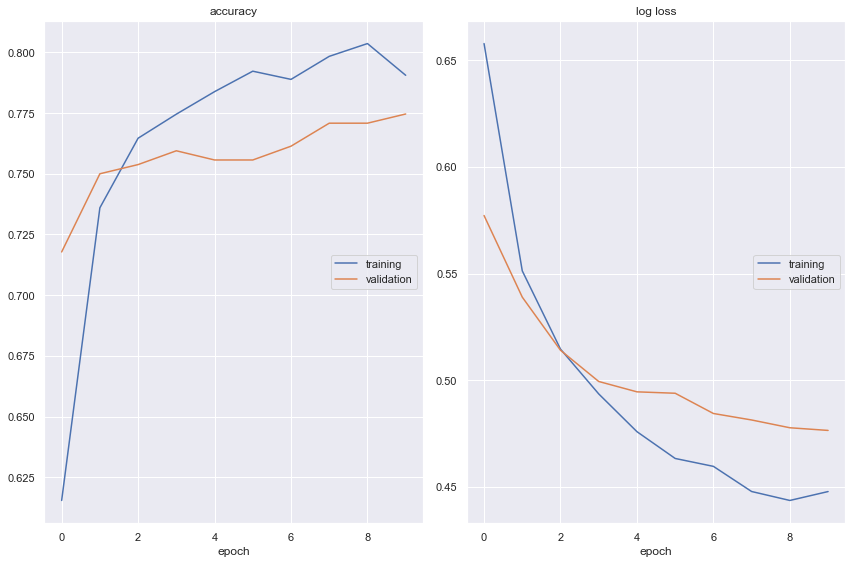

accuracy
	training         	 (min:    0.615, max:    0.804, cur:    0.791)
	validation       	 (min:    0.718, max:    0.775, cur:    0.775)
log loss
	training         	 (min:    0.444, max:    0.658, cur:    0.448)
	validation       	 (min:    0.477, max:    0.577, cur:    0.477)


In [124]:
train_model(model, criterion, optimizer, num_epochs=10)

In [125]:
def test_model(model, criterion):
    model.eval()
    
    correct = 0
    loss = 0
    
    with torch.no_grad():
        for inputs, labels in dataloaders['testing']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs).squeeze(1)
            loss += criterion(outputs, labels) * labels.size(0)
            correct += (torch.round(torch.sigmoid(outputs)) == labels).sum()
            
        accuracy = correct / len(dataloaders['testing'].dataset)
        error = loss / len(dataloaders['testing'].dataset)
    
        print('Testing Accuracy: %.4f   |   Testing Error: %.4f' % (
            accuracy, error))
        
test_model(model, criterion)

Testing Accuracy: 0.7998   |   Testing Error: 0.4324


In [111]:
# To load saved model parameters:
#model.load_state_dict(torch.load(path_to_save_params + 'epoch_3'))

<h1 style=font-size:25px;>Sci-Kit Learn Models</h1>

To begin with, we'll train, test and visualise some model classifiers using their default properties. This will allow us to get a feel for which algorithms are more likely to yield better performance.

In [126]:
# Train the models and record the results
def train_test_models1(classifiers, X_train, y_train, X_test, y_test, Xs_train, Xs_test):
    
    global roc_table
    accuracy_table = pd.DataFrame(columns=['classifiers','training_accuracy', 'testing_accuracy'])
    roc_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
    
    for cls in classifiers:
        
        # These models sensitive to feature scaling
        if cls.__class__.__name__ in ['LogisticRegression', 'KNeighborsClassifier', 'SVC']:
            X_train = Xs_train
            X_test = Xs_test
        
        # Train Model
        model = cls.fit(X_train, y_train)

        # Get Predictions/Probabilities
        y_prob = model.predict_proba(X_test)[:,1]  # probabilities for churned (i.e. 1 not 0)
        y_pred = model.predict(X_test)

        accuracy_tr = accuracy_score(y_train, model.predict(X_train))
        accuracy_te = accuracy_score(y_test, y_pred)
        
        accuracy_table = accuracy_table.append({'classifiers':cls.__class__.__name__,
                                                'training_accuracy':accuracy_tr, 
                                                'testing_accuracy':accuracy_te}, ignore_index=True)
        
        # ROC Curves
        fpr, tpr, _ = roc_curve(y_test,  y_prob)
        auc = roc_auc_score(y_test, y_prob)

        roc_table = roc_table.append({'classifiers':cls.__class__.__name__,
                                      'fpr':fpr, 
                                      'tpr':tpr, 
                                      'auc':auc}, ignore_index=True)
        
    roc_table.set_index('classifiers', drop=True, inplace=True)
    accuracy_table.set_index('classifiers', drop=True, inplace=True)
    return accuracy_table.style.highlight_max(color='yellow', subset=['testing_accuracy'])

# Plot ROC curves for each trained model
def plot_roc_curves(roc_table):
    fig = plt.figure(figsize=(10,8))

    for i in roc_table.index:
        plt.plot(roc_table.loc[i]['fpr'], 
                 roc_table.loc[i]['tpr'], 
                 label="{}, AUC={:.3f}".format(i, roc_table.loc[i]['auc']))
    
    plt.plot([0,1], [0,1], color='orange', linestyle='--')
    
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()

In [127]:
# Making list of classifiers to train and test
classifiers = [LogisticRegression(random_state=7), 
               GaussianNB(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier(random_state=7),
               RandomForestClassifier(random_state=7),
               SVC(probability=True),
               GradientBoostingClassifier(),
               AdaBoostClassifier(),
               xgb.XGBClassifier()]

In [128]:
# Training and Testing the classifiers
train_test_models1(classifiers, X_train, y_train, X_test, y_test, Xs_train, Xs_test)

,training_accuracy,testing_accuracy
classifiers,,
LogisticRegression,0.805271,0.807167
GaussianNB,0.695867,0.696246
KNeighborsClassifier,0.832006,0.762799
DecisionTreeClassifier,0.998104,0.741752
RandomForestClassifier,0.981418,0.787827
SVC,0.807736,0.800341
GradientBoostingClassifier,0.825559,0.800341
AdaBoostClassifier,0.809632,0.801479
XGBClassifier,0.934774,0.787258


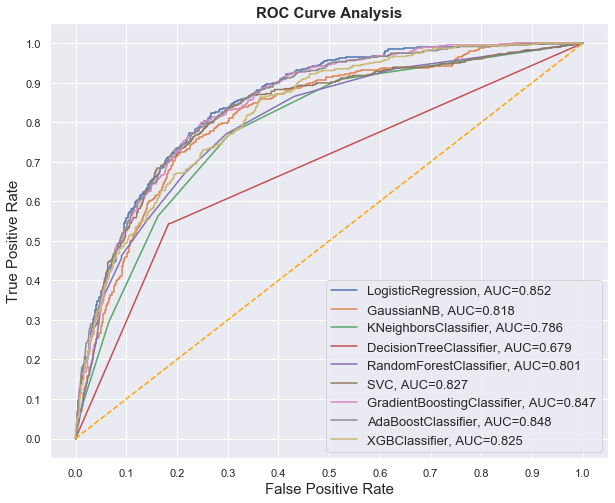

In [129]:
# Visualising ROC_AUC
plot_roc_curves(roc_table)

Observing all 9 models, the logisitic regression classifier has the best testing accuracy as well as the greatest AUC. However, on the other spectrum the gaussian naive bayes classifier has the worst testing accuracy, yet its AUC is not the lowest. Obviously, these results are mixed since each of the 9 models were trained only on the default values.

We'll now tune and measure the accuracies for the 9 models. The below tuning process was done using AWS EC2 where I manually set up the instance to run spark to take advantage of the parallel processing capabilities of sci-kit learns GridSearchCV running on a spark backend. The instance type I used was m4.16xlarge which uses 64 vCPUs and 256gb RAM (roughly $3-4 per compute hour).

In [2]:
# First we'll define a function to print out summary statistics
def print_model_info(fitted_model, X_train, y_train, X_test, y_test):
    print(f'''The best hyperparameters: {fitted_model.best_params_}
      \nThe best mean CV accuracy: {fitted_model.best_score_*100:.4f}%
      \nTraining Accuracy: {fitted_model.score(X_train, y_train)*100:.4f}%
      \nTesting Accuracy: {fitted_model.score(X_test, y_test)*100:.4f}%''')

<h2>Logistic Regression</h2>

In [94]:
# We'll use the standardise data
# Smaller C => stronger regularisation
param_grid = {
    'C': np.logspace(-3,3,7),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga', 'sag', 'lbfgs', 'newton-cg']
}
clf = LogisticRegression(n_jobs=-1)
clf_cv = GridSearchCV(clf, param_grid, cv=5)

with parallel_backend('spark', n_jobs=-1):
    clf_fitted = clf_cv.fit(Xs_train, y_train)

In [71]:
print_model_info(clf_fitted, Xs_train, y_train, Xs_test, y_test)
# Best params: c=0.1, penalty=l2, solver=saga

The best hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
      
The best mean CV accuracy: 80.3753%
      
Training Accuracy: 80.5840%
      
Testing Accuracy: 79.9772%


<h2>Gaussian Naive Bayes Classifier</h2>

In [91]:
# Not effected by feature scaling => using ordinary data
param_grid_gNB = {
    'var_smoothing': np.logspace(-9,-1,9)
}

clf_gNB = GaussianNB()
clf_gNB_cv = GridSearchCV(clf_gNB, param_grid_gNB, cv=10)

with parallel_backend('spark', n_jobs=-1):
    clf_gNB_fitted = clf_gNB_cv.fit(X_train, y_train)

In [67]:
print_model_info(clf_gNB_fitted, X_train, y_train, X_test, y_test)
# Best params: var_smoothing=0.0001

The best hyperparameters: {'var_smoothing': 0.0001}
      
The best mean CV accuracy: 78.4034%
      
Training Accuracy: 78.3656%
      
Testing Accuracy: 78.7258%


<h2>K-Nearest Neighbors Classifier</h2>

In [68]:
# Using Standardised Data
param_grid_knn = {
    'n_neighbors': np.arange(4, 9),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2],
    
}

clf_knn = KNeighborsClassifier(n_jobs=-1)
clf_knn_cv = GridSearchCV(clf_knn, param_grid_knn, cv=5)

with parallel_backend('spark', n_jobs=-1):
    clf_knn_fitted = clf_knn_cv.fit(Xs_train, y_train)

In [69]:
print_model_info(clf_knn_fitted, Xs_train, y_train, Xs_test, y_test)
# Best Params: algo=auto, leaf_size=10, n_neighbors=8, p=1, weights=uniform

The best hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
      
The best mean CV accuracy: 77.7970%
      
Training Accuracy: 82.0819%
      
Testing Accuracy: 78.2708%


<h2>Decision Tree Classifier</h2>

In [ ]:
# Since this is a tree-based algorithm, we'll use the plain ordinary data
param_grid_dtc = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 3, 4, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [int, float, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'min_impurity_decrease': [0.0, 0.01, 0.02, 0.05, 0.1]
}

clf_dtc = DecisionTreeClassifier()
clf_dtc_cv = GridSearchCV(clf_dtc, param_grid_dtc, cv=10)

with parallel_backend('spark', n_jobs=-1):
    clf_dtc_fitted = clf_dtc_cv.fit(X_train, y_train)

In [ ]:
print_model_info(clf_dtc_fitted, X_train, y_train, X_test, y_test)
# Best params: crit=gini, max_depth=None, max_feat=log2, max_leaf_node=10, min_imp_dec=0.0, min_samp_leaf=1,
# min_samp_split=2, splitter=best

<h2>Random Forest Classifier</h2>

In [ ]:
# Since this is a tree-based algorithm, we'll use the plain ordinary data
param_grid_rf = {
    'n_estimators': [100, 150, 200]
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 3, 4, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [int, float, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'min_impurity_decrease': [0.0, 0.01, 0.02, 0.05, 0.1]
}

clf_rf = RandomForestClassifier(n_jobs=-1)
clf_rf_cv = GridSearchCV(clf_rf, param_grid_rf, cv=10)

with parallel_backend('spark', n_jobs=-1):
    clf_rf_fitted = clf_rf_cv.fit(X_train, y_train)

In [ ]:
print_model_info(clf_rf_fitted, X_train, y_train, X_test, y_test)
# Best params: crit=gini, max_dep=None, max_feats=log2, max_leaf_nodes=20, min_imp_dec=0.0, min_samp_leaf=3,
# min_samp_split=2, n_estimators=150

<h2>Support Vector Machine Classifier</h2>

In [86]:
# Using the plain ordinary data since svc effected by feature scaling
param_grid_svc = {
    'C': np.logspace(-3, 3, 7),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

clf_svc = SVC()
clf_svc_cv = GridSearchCV(clf_svc, param_grid_svc, cv=5)

with parallel_backend('spark', n_jobs=-1):
    clf_svc_fitted = clf_svc_cv.fit(Xs_train, y_train)

In [87]:
print_model_info(clf_svc_fitted, Xs_train, y_train, Xs_test, y_test)
# Best params: c=0.1, gamma=scale, kernel=poly

The best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
      
The best mean CV accuracy: 80.1100%
      
Training Accuracy: 80.7736%
      
Testing Accuracy: 80.4323%


<h2>Gradient Boosted Classifier</h2>

In [74]:
# Since this is a tree-based algorithm, we'll use the plain ordinary data
param_grid_gb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 1],
    'n_estimators': [100, 125, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 5],
    'max_depth': [2, 3, 5, 7],
    'min_impurity_decrease': [0, 0.001, 0.01],
    'max_features': [None, 5, 10, 20]
}

clf_rb = GradientBoostingClassifier()
clf_rb_cv = GridSearchCV(clf_rb, param_grid_gb, cv=5)

with parallel_backend('spark', n_jobs=-1):
    clf_rb_fitted = clf_rb_cv.fit(X_train, y_train)

KeyboardInterrupt: 

In [73]:
print_model_info(clf_rb_fitted, X_train, y_train, X_test, y_test)
# Best params: lr=0.15, max_depth=2, max_features=sqrt, min_impur_dec=0.001, min_samp_leaf=2, 
#.             min_samp_split=10, n_est=150

NameError: name 'clf_rb_fitted' is not defined

<h2>AdaBoost Classifier</h2>

In [72]:
# Since this is a tree-based algorithm, we'll use the plain ordinary data
param_grid_ab = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 10, 100],
    'n_estimators': [50, 100, 150, 200],
    'algorithm': ['SAMME', 'SAMME.R']
}

clf_ab = AdaBoostClassifier()
clf_ab_cv = GridSearchCV(clf_ab, param_grid_ab, cv=10)

with parallel_backend('spark', n_jobs=-1):
    clf_ab_fitted = clf_ab_cv.fit(X_train, y_train)

In [3]:
print_model_info(clf_ab_fitted, X_train, y_train, X_test, y_test)
# Best params: algo=SAMME.R, learning_rate=0.5, n_estimators=200

NameError: name 'clf_ab_fitted' is not defined

<h2>XGBoost Classifier</h2>

In [ ]:
param_grid_xgb = {
    'n_estimators': [200],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.2, 0.3, 0.4], # same as xgb's eta
    'gamma': [0.0, 0.01, 0.05],
    'reg_alpha': [0.0, 0.01, 0.05, 0.1],
    'reg_lambda': [0.0, 0.1, 0.9, 1, 1.1],
    'max_delta_step': [0.0, 0.01, 0.05, 0.1],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'min_child_weight': [0.9, 1, 1.1, 2]
}

clf_xgb = xgb.XGBClassifier(n_jobs=1) # uses objective='binary:logistic'
clf_xgb_cv = GridSearchCV(clf_xgb, param_grid_xgb, cv=10)

with parallel_backend('spark', n_jobs=-1):
    clf_xgb_fitted = clf_xgb_cv.fit(X_train, y_train, early_stopping_rounds=10, 
                                    eval_metric="auc", eval_set=[(X_test, y_test)])

In [ ]:
print_model_info(clf_xgb_fitted, X_train, y_train, X_test, y_test)
# Best params: colsample_bytre=0.5, gamma=0.0, lr=0.2, max_delta_step=0.0, max_depth=5, min_child_weight=0.9,
#              n_estimators=50, reg_lambda=1, subsample=0.5

<h2><u>Final Remarks</u></h2>

After tuning all 9 models the AdaBoost Classifier yields the best testing accuracy of 80.6030% while also not severely overfitting the data with a training accuracy of 81.1339%. 

Tuning did play an important role, because using the default parameters the logistic regression model yielded the best testing accuracy, however, after tuning the logistic regression model the testing accuracy has fallen.